In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt



### Thresholding

In [4]:
def thresholding(image, tol=1, tau=20):
    while True:
        segmentation = image >= tau

        # Background
        mBG = image[segmentation == False]
        if len(mBG) > 0:
            mBG = np.nan_to_num(mBG, nan=0)
            mBG = mBG.mean()
        else:
            mBG = 0

        # Foreground
        mFG = image[segmentation]
        if len(mFG) > 0:
            mFG = np.nan_to_num(mFG, nan=0)
            mFG = mFG.mean()
        else:
            mFG = 0

        # Update tau
        tau_post = 0.5 * (mBG + mFG)

        # Check if accepts the tolerance, if not, continue iterating
        if np.abs(tau - tau_post) < tol:
            break
        else:
            tau = tau_post

    return segmentation

In [3]:
def k_means(image, ks,iteracion=10):
        
    # Inicialización de valores k
    k_values = np.linspace(np.amin(image), np.amax(image), ks)
    # iteracion=10
    for i in range(iteracion):
        d_values = [np.abs(k - image) for k in k_values]
        segmentationr = np.argmin(d_values, axis=0)

        for k_idx in range(ks):
            k_values[k_idx] = np.mean(image[segmentationr == k_idx])

    return segmentationr

In [5]:
def region_growing(image, x=100, y=100, z=20, tol=50):
    segmentation = np.zeros_like(image)
    if segmentation[x,y,z] == 1:
        return
    valor_medio_cluster = image[x,y,z]
    segmentation[x,y,z] = 1
    vecinos = [(x, y, z)]
    while vecinos:
        x, y, z = vecinos.pop()
        for dx in [-1,0,1]:
            for dy in [-1,0,1]:
                for dz in [-1,0,1]:
                    #vecino
                    nx, ny, nz = x + dx, y + dy, z + dz
                    if nx >= 0 and nx < image.shape[0] and \
                        ny >= 0 and ny < image.shape[1] and \
                        nz >= 0 and nz < image.shape[2]:
                        if np.abs(valor_medio_cluster - image[nx,ny,nz]) < tol and \
                            segmentation[nx,ny,nz] == 0:
                            segmentation[nx,ny,nz] = 1
                            vecinos.append((nx, ny, nz))
    return segmentation

### Remove skull 1

Cantidad de elementos igual a 2: 2014770


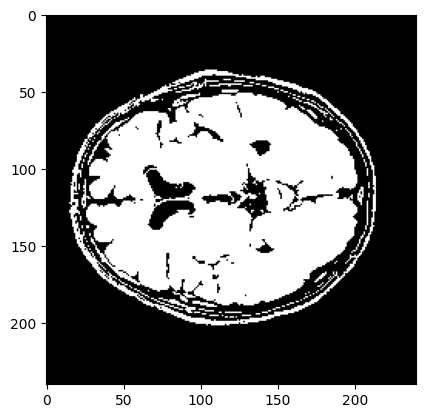

In [9]:
image_data_FLAIR = nib.load("../../images/1/FLAIR.nii.gz").get_fdata()
image_data_T1 = nib.load("../../images/1/T1.nii.gz").get_fdata()
image_data_IR = nib.load("../../images/1/IR.nii.gz").get_fdata()

# segmentate_flair = thresholding(image_data_FLAIR)
# segmentate_ir = thresholding(image_data_IR)

segmentate_flair = k_means(image_data_FLAIR, 3)
segmentate_ir = k_means(image_data_IR, 3)

# Asignar 2 a los números iguales a 2 y 0 al resto
result = np.where(segmentate_flair == 1, 1, 0)

# Contar los valores iguales a 2 en la matriz
count = np.count_nonzero(segmentate_flair == 0)

# Imprimir el resultado
print("Cantidad de elementos igual a 2:", count)

# Apply binary operation AND to segmentations
mask = np.logical_and(segmentate_flair, segmentate_ir)*-1

# Apply the mask to the FLAIR image to remove skull
image_data_FLAIR = np.multiply(image_data_FLAIR, mask)

# Plot the image
fig, ax = plt.subplots()
ax.imshow(result[:, :, 20], cmap="gray")
plt.show()

### Remove Skull Camila

In [162]:
from scipy import ndimage
import SimpleITK as sitk

# Cargar la imagen NIfTI
nifti_img = nib.load('../../temp_images/registered_IR.nii.gz')  # Asegúrate de ajustar la ruta y el nombre del archivo

# Obtener los datos de la imagen
data = nifti_img.get_fdata()

# Definir escalas espaciales
scales = [7.5]  # Escalas para aplicar filtros gaussianos

# Aplicar filtros gaussianos en diferentes escalas
filtered_images = []
for scale in scales:
    # Aplicar filtro gaussiano
    filtered = ndimage.gaussian_filter(data, sigma=scale)
    filtered = k_means(filtered, 2)
    # Crear una nueva imagen nibabel con el cerebro extraído
    brain_extracted_image = nib.Nifti1Image(filtered, affine=nifti_img.affine, dtype=np.int16)
    
    # Guardar la imagen con el cerebro extraído en un nuevo archivo
    nib.save(brain_extracted_image, 'IR_skull.nii.gz')
    filtered_images.append(filtered)

# RESTAR UNA IMAGEN 

# Cargar las imágenes
imagen_original = sitk.ReadImage('../../temp_images/registered_T1.nii.gz')
imagen_referencia = sitk.ReadImage('IR_skull.nii.gz')

# Modify the metadata of image2 to match image1
imagen_referencia.SetOrigin(imagen_original.GetOrigin())
imagen_referencia.SetSpacing(imagen_original.GetSpacing())
imagen_referencia.SetDirection(imagen_original.GetDirection())

# Realizar segmentación basada en umbral adaptativo
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(1)
otsu_filter.SetOutsideValue(0)
mascara_referencia = otsu_filter.Execute(imagen_referencia)

# Aplicar la máscara a la imagen original
imagen_sin_craneo = sitk.Mask(imagen_original, mascara_referencia)

# Obtener los datos de la imagen sin el cráneo
# Obtener los datos de la imagen sin el cráneo
data_sin_craneo = sitk.GetArrayFromImage(imagen_sin_craneo)

# Obtener los datos de la máscara
data_mascara = sitk.GetArrayFromImage(mascara_referencia)

# Crear una máscara booleana para los valores cero dentro del cerebro
mascara_cero_cerebro = (data_sin_craneo == 0) & (data_mascara != 0)

# Asignar un valor distinto a los valores cero dentro del cerebro
valor_distinto = 6
data_sin_craneo[mascara_cero_cerebro] = valor_distinto

# Crear una nueva imagen SimpleITK con los datos modificados
imagen_sin_craneo_modificada = sitk.GetImageFromArray(data_sin_craneo)
imagen_sin_craneo_modificada.CopyInformation(imagen_sin_craneo)

# Guardar la imagen sin el cráneo
sitk.WriteImage(imagen_sin_craneo_modificada, 'FLAIR_skull.nii.gz')
# files.download('FLAIR_skull.nii.gz')

In [163]:
# Cargar las imágenes
imagen_original = sitk.ReadImage('../../images/1/FLAIR.nii.gz')
imagen_referencia = sitk.ReadImage('IR_skull.nii.gz')

# Realizar segmentación basada en umbral adaptativo
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(1)
otsu_filter.SetOutsideValue(0)
mascara_referencia = otsu_filter.Execute(imagen_referencia)

# Aplicar la máscara a la imagen original
imagen_sin_craneo = sitk.Mask(imagen_original, mascara_referencia)

# Guardar la imagen sin el cráneo
sitk.WriteImage(imagen_sin_craneo, 'FLAIR_original_sin_craneo.nii.gz')

In [164]:
# remove()

image = nib.load('FLAIR_skull.nii.gz')
image_data = image.get_fdata()
image_data_flair = nib.load('FLAIR_original_sin_craneo.nii.gz').get_fdata()

image_data_segmented = k_means(image_data_flair, 3, 15)


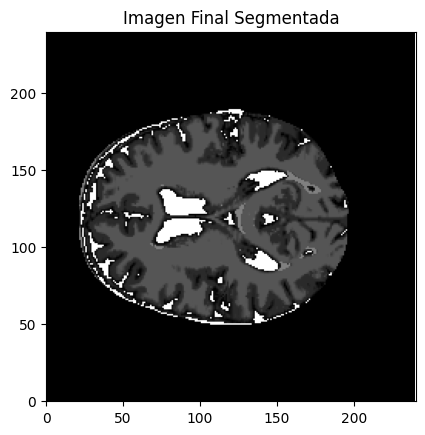

In [191]:

# Plot only image_data_segmented with only the values of 3
# result = np.where(image_data_segmented == 2, 1, 0)

# # All the values below the slice 13, replace them with 0
# result[:,:,:13] = 0


# Where the values are 1, replace them in the image_data with a value of 3
image_data_segmented[:,:,:13] = 0
image_data = np.where(image_data_segmented == 2, 3, image_data)


# Añade el título
plt.title('Imagen Final Segmentada')
plt.xlim(0 , 240)
plt.ylim(0 , 240)
plt.imshow(image_data[:, :, 23], cmap="gray")
plt.show()

affine = image.affine
# Create a nibabel image object from the image data
image = nib.Nifti1Image(image_data.astype(np.float32), affine=affine)
# Save the image as a NIfTI file
output_path = "FLAIR_skull_lesion.nii.gz"
nib.save(image, output_path)

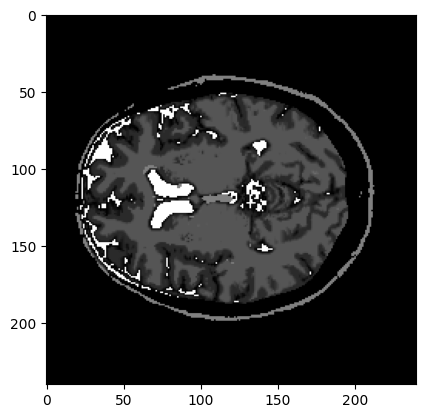

### Count Voxels

[0 1 2 3 4]
LABEL #0 - Cantidad de voxeles: 2153227 - volumen en mm3: 5452939.85
LABEL #1 - Cantidad de voxeles: 417653 - volumen en mm3: 1057685.37
LABEL #2 - Cantidad de voxeles: 190957 - volumen en mm3: 483589.07
LABEL #3 - Cantidad de voxeles: 2913 - volumen en mm3: 7377.03
LABEL #4 - Cantidad de voxeles: 50 - volumen en mm3: 126.62


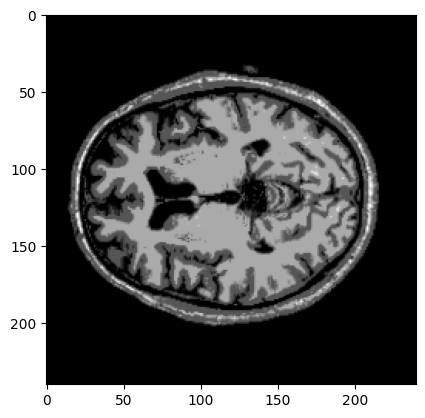

In [60]:
image_data = nib.load("../../temp_images/FLAIR.nii.gz")
image_data_FLAIR = image_data.get_fdata()


# Asignar 2 a los números iguales a 2 y 0 al resto
# result = np.where(image_data_FLAIR == 4, 1, 0)

# Para cada valor en la matriz, hacer la cuenta de cuantos elementos de ese valor hay
unique, counts = np.unique(image_data_FLAIR.astype(np.int32), return_counts=True)
print(unique)
voxel_size = np.abs(image_data.affine.diagonal()[:3])

# For each unique value, calculate volume
for i in range(len(unique)):
    count = 0
    volume_in_mm3 = 0

    count = np.count_nonzero(image_data_FLAIR.astype(np.int32) == i)
    volume_in_mm3 = count * np.prod(voxel_size)

    # Imprimir el resultado
    print(f"LABEL #{i} - Cantidad de voxeles: {count} - volumen en mm3: {volume_in_mm3.round(2)}")
    # print(f"Volumen del label #{i}:", volume_in_mm3)


# Plot the image
fig, ax = plt.subplots()
ax.imshow(image_data_FLAIR[:, :, 20], cmap="gray")
plt.show()

In [ ]:
image_data_FLAIR_Registrada = nib.load("../../temp_images/FLAIR.nii.gz").get_fdata()
image_data_T1_Segmentada = nib.load("../../temp_images/T1.nii.gz").get_fdata()
image_data_FLAIR = nib.load("../../images/1/FLAIR.nii.gz").get_fdata()

# Plot the image
# fig, ax = plt.subplots()
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# # Show image in the first subplot
# ax1.set_xlim([0, image_data_FLAIR.shape[0]])
# ax1.set_ylim([0, image_data_FLAIR.shape[1]])
# ax1.imshow(image_data_FLAIR[:, :, 20], cmap="gray")
# ax1.set_title('Imagen FLAIR')

# # Show image in the second subplot
# ax2.set_xlim([0, image_data_T1_Segmentada.shape[0]])
# ax2.set_ylim([0, image_data_T1_Segmentada.shape[1]])
# ax2.imshow(image_data_T1_Segmentada[:, :, 80], cmap="gray")
# ax2.set_title('Imagen T1 Segmentada')

# # Show image in the second subplot
# ax3.set_xlim([0, image_data_FLAIR_Registrada.shape[0]])
# ax3.set_ylim([0, image_data_FLAIR_Registrada.shape[1]])
# ax3.imshow(image_data_FLAIR_Registrada[:, :, 20], cmap="gray")
# ax3.set_title('Imagen Registrada')



# # Show image in the first subplot
# ax2.imshow(image_data_T1_Segmentada[:, :, 80], cmap="gray")

# # Display the plot using Streamlit
# # ax.imshow(image_data_FLAIR_Registrada[:, :, 80], cmap="gray")
# plt.show()


In [20]:
image_data_T1 = nib.load("../../images/1/T1.nii.gz").get_fdata()

# Plot the image
image_data_T1_Segmentada = k_means(image_data_T1, 5)

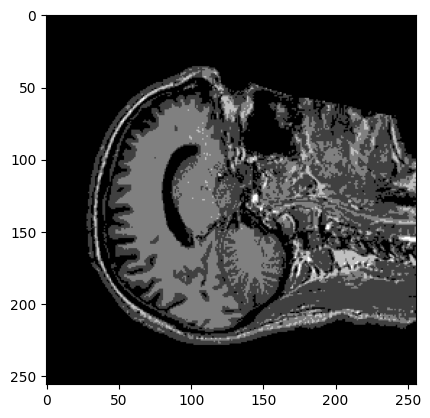

In [28]:
# Plot the image
fig, ax = plt.subplots()
ax.imshow(image_data_T1_Segmentada[:, :, 80], cmap="gray")
plt.show()

In [47]:
image_data_T1_Segmentada_REGION = region_growing(image_data_T1, 131, 97, 24, 150)


KeyboardInterrupt: 

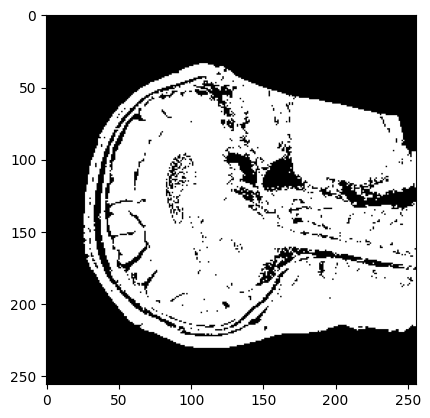

In [46]:


# Plot the image
fig, ax = plt.subplots()
ax.imshow(image_data_T1_Segmentada_REGION[:, :, 100], cmap="gray")
plt.show()


